In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import trange
import cv2 as cv
import pof_piv as piv

# %load_ext autoreload
# %autoreload 2

In [3]:
def divide_in_n_windows(images, window_counts, margins=[0, 0, 0, 0]):
    """
    Divide a set of images into windows of a given (equal!) size.

    PARAMETERS:
        images (np.array): Images [c, y, x].
        window_counts (tuple): Number of windows in each dimension [j, i].
        margins (list of ints): Number of pixels to cut off from the edges of the
            images [y0, y1, x0, x1].

    RETURNS:
        windows (list of lists): Windows [c, j, i, j_y, i_x].
        centers (np.array): Subpixel coordinates of the centre of each window [j, i, y/x].
        locations (np.array): Coordinates of the top-left corner of each window [y, x].
    """

    # Check whether one or multiple images was supplied
    if len(images.shape) == 2:
        # If only one image was supplied, add a dimension
        images = images[np.newaxis, :, :]

    # Cut off a number of pixels in each direction given by margins
    images = images[:, margins[0]:(images.shape[1]-margins[1]),
                 margins[2]:(images.shape[2]-margins[3])]
        
    # Get the cropped image size
    crop_size = images.shape[1:]
        
    # Calculate the subpixel window size
    window_size = np.array(crop_size) / window_counts
    
    # Get the subpixel window centers
    centers_y = np.linspace(0.5 * window_size[0], crop_size[0] 
                                - 0.5 * window_size[0], window_counts[0])
    centers_x = np.linspace(0.5 * window_size[1], crop_size[1]
                                - 0.5 * window_size[1], window_counts[1])

    # From these, calculate the top-left pixel indices of the windows within 
    # the uncropped image
    locations = np.array([[[margins[0] + int(y - 0.5 * window_size[0]),
                   margins[2] + int(x - 0.5 * window_size[1])] 
                    for x in centers_x] for y in centers_y])

    # Divide the images into windows of approximately equal size
    windows = [[images[:, int(y - 0.5 * window_size[0]):
                          int(y + 0.5 * window_size[0]),
                int(x - 0.5 * window_size[1]):
                int(x + 0.5 * window_size[1])]
                for x in centers_x] for y in centers_y]

    # Center coordinates
    centers = np.array([[[margins[0] + y, margins[2] + x] for x in centers_x] 
                        for y in centers_y])

    # Finally, calculate the size of each window
    sizes = np.array([[window.shape[1:] for window in col] for col in windows])

    return windows, centers, locations, sizes

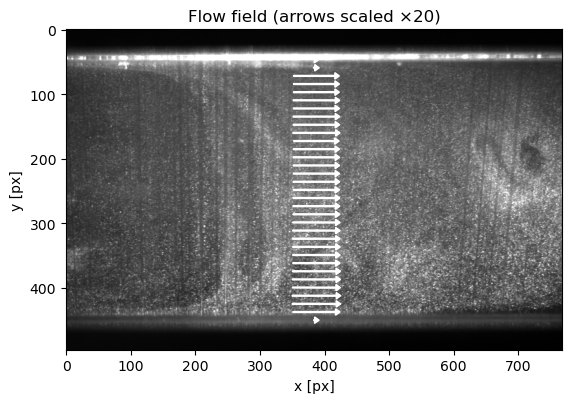

In [4]:
window_counts = (33, 1)
directory = 'piv_examples/pos1-5'
margins = [40, 40, 0, 0]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# # Load final image from the series
# final_image = cv.imread('data/pos1-5/240404_PIV5008761.tif', cv.IMREAD_GRAYSCALE)
# 
# # Subtract from other images
# for i, image in enumerate(images):
#     image = image - final_image
#     image[image > 255] = 0
#     images[i] = image

# Divide the images into windows
windows, centers, locations, sizes = divide_in_n_windows(images, window_counts, margins=margins)

# Check whether the windows in the vertical direction are of equal size
try:
    assert np.all([np.all([window.shape[2] == windows[0][0].shape[2] for window in row]) for row in windows])
except AssertionError:
    raise ValueError(f'An image of width {images[0].shape[1] - margins[2] - margins[3]} could not be divided into {window_counts[1]} windows of equal width.')

# Calculate the correlation of each window [j, i] in frame 0 with the
# corresponding window in frame 1
correlations = [[piv.correlate_image_pair(windows[j][i][0], windows[j][i][1], plot=False)
                          for i in range(window_counts[1])]
                         for j in range(window_counts[0])]

displacements = np.array([[piv.find_displacement(correlation) for correlation in row] for row in correlations])

# Add up all correlation images in the horizontal direction
correlation_rows = [np.sum(row, axis=0) for row in correlations]

# Average the x coordinates of the windows
centers = np.mean(centers, axis=1)
centers = np.expand_dims(centers, axis=1)

# Calculate the displacement of each window [j, i] in frame 0 with the
# corresponding window in frame 1
displacements = np.array([piv.find_displacement(correlation) for correlation in correlation_rows])
# 
# # Add an extra axis to the displacements at position 1 to match the plot function
displacements = np.expand_dims(displacements, axis=1)
# 
# # Plot the flow field
_,_ = plot_flow_field(displacements, centers, plot_windows=False, background=images[0], arrow_scale=20, arrow_color='white')

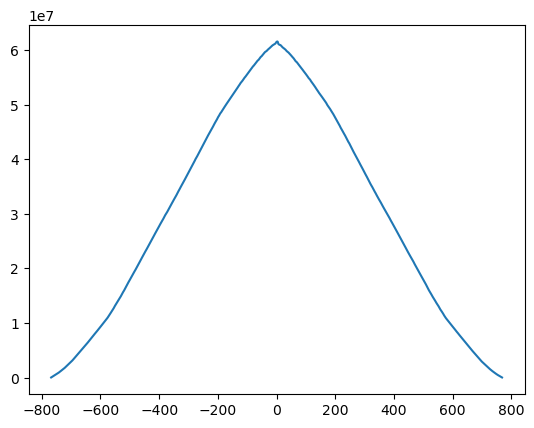

In [5]:
plt.plot(np.linspace(-768, 768, 1535), correlation_rows[4][11, :])
row = correlation_rows[4][11, :]

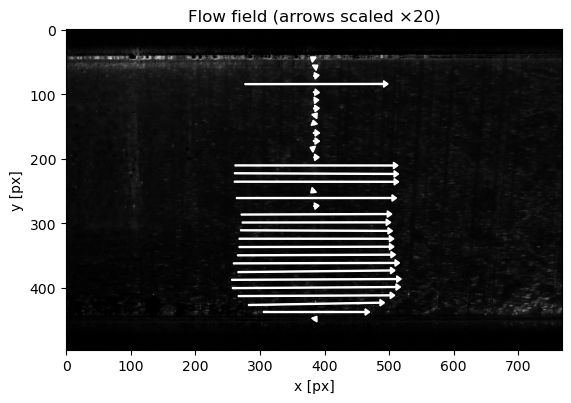

In [15]:
window_counts = (33, 1)
directory = 'piv_examples/pos1-7'
margins = [40, 40, 0, 0]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Load final image from the series
final_image = cv.imread('data/pos1-7/240404_PIV7010301.tif', cv.IMREAD_GRAYSCALE)

# Subtract from other images
for i, image in enumerate(images):
    image = image - final_image
    image[image > 255] = 0
    images[i] = image

# Divide the images into windows
windows, centers, locations, sizes = divide_in_n_windows(images, window_counts, margins=margins)

# Check whether the windows in the vertical direction are of equal size
try:
    assert np.all([np.all([window.shape[2] == windows[0][0].shape[2] for window in row]) for row in windows])
except AssertionError:
    raise ValueError(f'An image of width {images[0].shape[1]} could not be divided into {window_counts[1]} windows of equal width.')

# Calculate the correlation of each window [j, i] in frame 0 with the
# corresponding window in frame 1
correlations = [[piv.correlate_image_pair(windows[j][i][0], windows[j][i][1], plot=False)
                          for i in range(window_counts[1])]
                         for j in range(window_counts[0])]

displacements = np.array([[piv.find_displacement(correlation) for correlation in row] for row in correlations])

# Add up all correlation images in the horizontal direction
# correlation_rows = [np.sum(row, axis=0) for row in correlations]

# Average the x coordinates of the windows
# centers[0, :, 1] = np.mean(centers[0, :, 1])
# centers = np.expand_dims(centers[:, 0, :], axis=1)

# Calculate the displacement of each window [j, i] in frame 0 with the
# corresponding window in frame 1
# displacements = np.array([piv.find_displacement(correlation) for correlation in correlation_rows])

# Add an extra axis to the displacements at position 1 to match the plot function
# displacements = np.expand_dims(displacements, axis=1)

# Plot the flow field
_,_ = plot_flow_field(displacements, centers, plot_windows=False, background=images[0], arrow_scale=20, arrow_color='white')

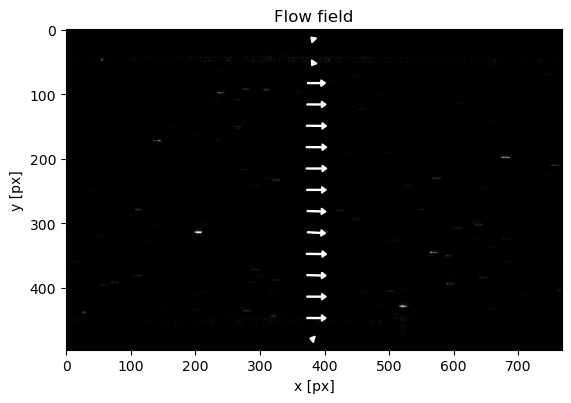

In [20]:
window_counts = (15, 2)
directory = 'piv_examples/pos2-4'
margins = [0, 0, 0, 0]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Load final image from the series
final_image = cv.imread('data/pos2-4/240404_PIV4013084.tif', cv.IMREAD_GRAYSCALE)

# Subtract from other images
for i, image in enumerate(images):
    image = image - final_image
    image[image > 255] = 0
    images[i] = image

# Divide the images into windows
windows, centers, locations, sizes = divide_in_n_windows(images, window_counts, margins=margins)

# Check whether the windows in the vertical direction are of equal size
try:
    assert np.all([np.all([window.shape[2] == windows[0][0].shape[2] for window in row]) for row in windows])
except AssertionError:
    raise ValueError(f'An image of width {images[0].shape[1]} could not be divided into {window_counts[1]} windows of equal width.')

# Calculate the correlation of each window [j, i] in frame 0 with the
# corresponding window in frame 1
correlations = [[piv.correlate_image_pair(windows[j][i][0], windows[j][i][1], plot=False)
                          for i in range(window_counts[1])]
                         for j in range(window_counts[0])]

displacements = np.array([[piv.find_displacement(correlation) for correlation in row] for row in correlations])

# Add up all correlation images in the horizontal direction
correlation_rows = [np.sum(row, axis=0) for row in correlations]

# Average the x coordinates of the windows
centers = np.mean(centers, axis=1)
centers = np.expand_dims(centers, axis=1)

# Calculate the displacement of each window [j, i] in frame 0 with the
# corresponding window in frame 1
displacements = np.array([piv.find_displacement(correlation) for correlation in correlation_rows])
# 
# # Add an extra axis to the displacements at position 1 to match the plot function
displacements = np.expand_dims(displacements, axis=1)
# 
# # Plot the flow field
_,_ = plot_flow_field(displacements, centers, plot_windows=False, background=images[0], arrow_scale=1, arrow_color='white')

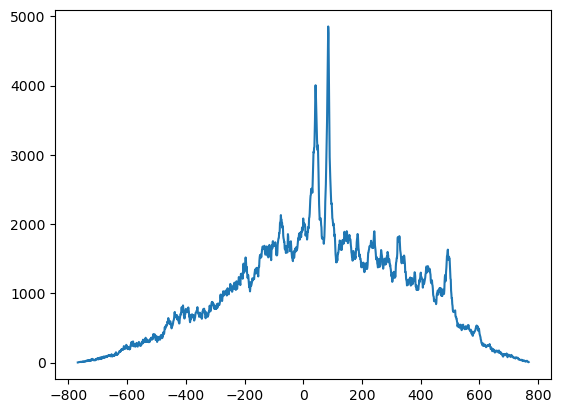

In [8]:
# Plot the intensity values of the middle row of the fourth correlation row
plt.plot(np.linspace(-768, 768, 1535), correlation_rows[4][16, :])

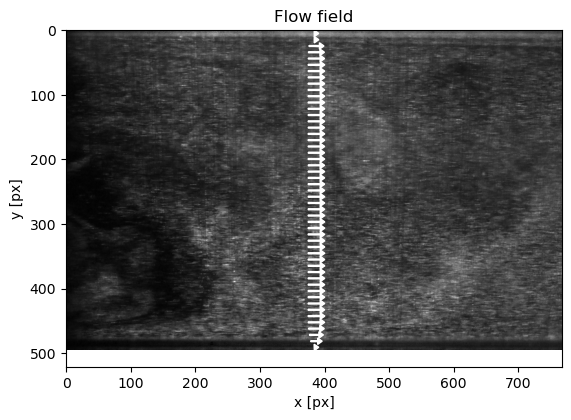

In [9]:
window_counts = (51, 1)
directory = 'piv_examples/pos3-2'
margins = [0, 0, 0, 0]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Load final image from the series
final_image = cv.imread('data/backgrounds/pos3-2.tif', cv.IMREAD_GRAYSCALE)

# Subtract from other images
for i, image in enumerate(images):
    image = image - final_image
    image[image > 255] = 0
    images[i] = image

# Divide the images into windows
windows, centers, locations, sizes = divide_in_n_windows(images, window_counts, margins=margins)

# Check whether the windows in the vertical direction are of equal size
try:
    assert np.all([np.all([window.shape[2] == windows[0][0].shape[2] for window in row]) for row in windows])
except AssertionError:
    raise ValueError(f'An image of width {images[0].shape[1]} could not be divided into {window_counts[1]} windows of equal width.')

# Calculate the correlation of each window [j, i] in frame 0 with the
# corresponding window in frame 1
correlations = [[piv.correlate_image_pair(windows[j][i][0], windows[j][i][1], plot=False)
                          for i in range(window_counts[1])]
                         for j in range(window_counts[0])]

displacements = np.array([[piv.find_displacement(correlation) for correlation in row] for row in correlations])

# Add up all correlation images in the horizontal direction
correlation_rows = [np.sum(row, axis=0) for row in correlations]

# Average the x coordinates of the windows
centers = np.mean(centers, axis=1)
centers = np.expand_dims(centers, axis=1)

# Calculate the displacement of each window [j, i] in frame 0 with the
# corresponding window in frame 1
displacements = np.array([piv.find_displacement(correlation) for correlation in correlation_rows])
# 
# # Add an extra axis to the displacements at position 1 to match the plot function
displacements = np.expand_dims(displacements, axis=1)
# 
# # Plot the flow field
_,_ = plot_flow_field(displacements, centers, plot_windows=False, background=images[0], arrow_scale=1, arrow_color='white')

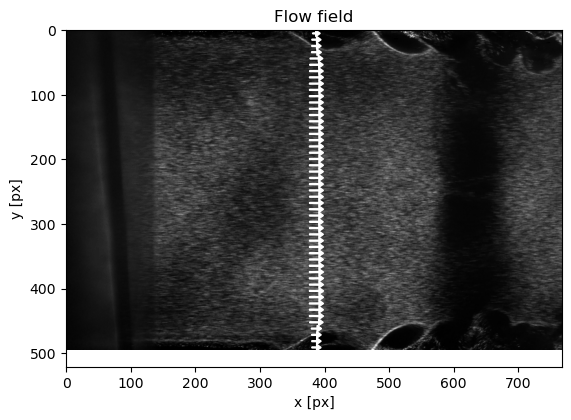

In [10]:
window_counts = (51, 1)
directory = 'piv_examples/pos4-2'
margins = [0, 0, 0, 0]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Load final image from the series
final_image = cv.imread('data/backgrounds/pos4-2.tif', cv.IMREAD_GRAYSCALE)

# Subtract from other images
for i, image in enumerate(images):
    image = image - final_image
    image[image > 255] = 0
    images[i] = image

# Divide the images into windows
windows, centers, locations, sizes = divide_in_n_windows(images, window_counts, margins=margins)

# Check whether the windows in the vertical direction are of equal size
try:
    assert np.all([np.all([window.shape[2] == windows[0][0].shape[2] for window in row]) for row in windows])
except AssertionError:
    raise ValueError(f'An image of width {images[0].shape[1]} could not be divided into {window_counts[1]} windows of equal width.')

# Calculate the correlation of each window [j, i] in frame 0 with the
# corresponding window in frame 1
correlations = [[piv.correlate_image_pair(windows[j][i][0], windows[j][i][1], plot=False)
                          for i in range(window_counts[1])]
                         for j in range(window_counts[0])]

displacements = np.array([[piv.find_displacement(correlation) for correlation in row] for row in correlations])

# Add up all correlation images in the horizontal direction
correlation_rows = [np.sum(row, axis=0) for row in correlations]

# Average the x coordinates of the windows
centers = np.mean(centers, axis=1)
centers = np.expand_dims(centers, axis=1)

# Calculate the displacement of each window [j, i] in frame 0 with the
# corresponding window in frame 1
displacements = np.array([piv.find_displacement(correlation) for correlation in correlation_rows])
# 
# # Add an extra axis to the displacements at position 1 to match the plot function
displacements = np.expand_dims(displacements, axis=1)
# 
# # Plot the flow field
_,_ = plot_flow_field(displacements, centers, plot_windows=False, background=images[0], arrow_scale=1, arrow_color='white')

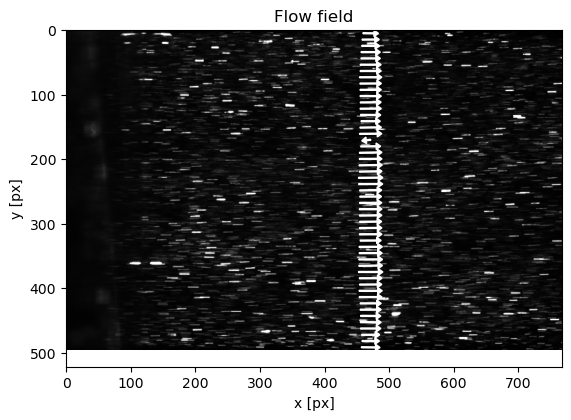

30.59907619767722

In [22]:
window_counts = (51, 4)
directory = 'piv_examples/pos4-4'
margins = [0, 0, 168, 0]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Load final image from the series
final_image = cv.imread('data/backgrounds/pos4-4.tif', cv.IMREAD_GRAYSCALE)

# Subtract from other images
for i, image in enumerate(images):
    image = image - final_image
    image[image > 255] = 0
    images[i] = image

# Divide the images into windows
windows, centers, locations, sizes = divide_in_n_windows(images, window_counts, margins=margins)

# Check whether the windows in the vertical direction are of equal size
try:
    assert np.all([np.all([window.shape[2] == windows[0][0].shape[2] for window in row]) for row in windows])
except AssertionError:
    raise ValueError(f'An image of width {images[0].shape[1] - margins[2] - margins[3]} could not be divided into {window_counts[1]} windows of equal width.')

# Calculate the correlation of each window [j, i] in frame 0 with the
# corresponding window in frame 1
correlations = [[piv.correlate_image_pair(windows[j][i][0], windows[j][i][1], plot=False)
                          for i in range(window_counts[1])]
                         for j in range(window_counts[0])]

displacements = np.array([[piv.find_displacement(correlation) for correlation in row] for row in correlations])

# Add up all correlation images in the horizontal direction
correlation_rows = [np.sum(row, axis=0) for row in correlations]

# Average the x coordinates of the windows
centers = np.mean(centers, axis=1)
centers = np.expand_dims(centers, axis=1)

# Calculate the displacement of each window [j, i] in frame 0 with the
# corresponding window in frame 1
displacements = np.array([piv.find_displacement(correlation) for correlation in correlation_rows])
# 
# # Add an extra axis to the displacements at position 1 to match the plot function
displacements = np.expand_dims(displacements, axis=1)
# 
# # Plot the flow field
_,_ = plot_flow_field(displacements, centers, plot_windows=False, background=images[0], arrow_scale=1, arrow_color='white')

np.max(displacements)

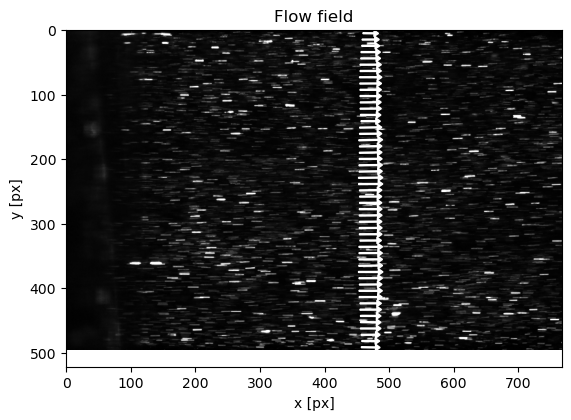

30.83764064344166

In [12]:
window_counts = (51, 1)
directory = 'piv_examples/pos4-4'
margins = [0, 0, 168, 0]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Load final image from the series
final_image = cv.imread('data/backgrounds/pos4-4.tif', cv.IMREAD_GRAYSCALE)

# Subtract from other images
for i, image in enumerate(images):
    image = image - final_image
    image[image > 255] = 0
    images[i] = image

# Divide the images into windows
windows, centers, locations, sizes = divide_in_n_windows(images, window_counts, margins=margins)

# Check whether the windows in the vertical direction are of equal size
try:
    assert np.all([np.all([window.shape[2] == windows[0][0].shape[2] for window in row]) for row in windows])
except AssertionError:
    raise ValueError(f'An image of width {images[0].shape[1] - margins[2] - margins[3]} could not be divided into {window_counts[1]} windows of equal width.')

# Calculate the correlation of each window [j, i] in frame 0 with the
# corresponding window in frame 1
correlations = [[piv.correlate_image_pair(windows[j][i][0], windows[j][i][1], plot=False)
                          for i in range(window_counts[1])]
                         for j in range(window_counts[0])]

displacements = np.array([[piv.find_displacement(correlation) for correlation in row] for row in correlations])

# Add up all correlation images in the horizontal direction
correlation_rows = [np.sum(row, axis=0) for row in correlations]

# Average the x coordinates of the windows
centers = np.mean(centers, axis=1)
centers = np.expand_dims(centers, axis=1)

# Calculate the displacement of each window [j, i] in frame 0 with the
# corresponding window in frame 1
displacements = np.array([piv.find_displacement(correlation) for correlation in correlation_rows])
# 
# # Add an extra axis to the displacements at position 1 to match the plot function
displacements = np.expand_dims(displacements, axis=1)
# 
# # Plot the flow field
_,_ = plot_flow_field(displacements, centers, plot_windows=False, background=images[0], arrow_scale=1, arrow_color='white')
np.max(displacements)